In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import statsmodels.api as sm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


## Import Dataset

Import the dataset to do Feature Engineering

In [10]:
df = pd.read_csv("cleaned_housing_model_data.csv")

In [11]:
stringency = pd.read_csv("C:\\Users\\Kevin\\state_stringency_by_year.csv")

In [12]:
# Rename state column in stringency to match df
stringency.rename(columns={'State': 'County State'}, inplace=True)

# Merge on the state name
df = df.merge(stringency, on='County State', how='left')

## Feature engineering
Now we need to do some feature engineering. We will get population density, housing growth, housing density, unemployment trends, 

In [13]:
# Create mean stringency score
df['Stringency_Mean'] = df[['Stringency_2020', 'Stringency_2021']].mean(axis=1)

#drop the original two columns to simplify model
df.drop(columns=['Stringency_2020', 'Stringency_2021'], inplace=True)

In [14]:
df = df[df['Rent (Smoothed)'] < 7500]

In [15]:
# population density
df['pop_density'] = df['POPESTIMATE2022'] /df['ALAND']

In [16]:
# housing unit growth
df['housing_unit_growth'] = df['housing_units_2022'] - df['housing_units_2020']
df['housing_unit_pct_growth'] = df['housing_unit_growth'] / df['housing_units_2020']


In [17]:
# housing density
df['housing_unit_density'] = df['housing_units_2022'] / df['ALAND']

In [18]:
# unemployment trends
df['unemp_trend'] = df['unemp_22'] - df['unemp_20']
df['unemp_mean'] = df[['unemp_20', 'unemp_21', 'unemp_22']].mean(axis=1)

In [19]:
df = df.sort_values(by=['zip_code', 'Home Type', 'date'])

# Monthly change in rent (smoothed)
df['rent_delta'] = df.groupby(['zip_code', 'Home Type'])['Rent (Smoothed)'].diff()

# Percentage change
df['rent_pct_change'] = df.groupby(['zip_code', 'Home Type'])['Rent (Smoothed)'].pct_change()


In [20]:
# 3-month rolling rent volatility
df['rent_volatility'] = df.groupby(['zip_code', 'Home Type'])['Rent (Smoothed)'].transform(
    lambda x: x.rolling(window=3, min_periods=2).std()
)


In [21]:
df.isnull().sum().sort_values(ascending=False).head(15)


county_name                319627
city_name                  319627
msa_name                   319627
rent_volatility              6229
rent_pct_change              6229
rent_delta                   6229
housing_units_2019           3375
housing_units_2021           3375
housing_units_2022           3375
housing_units_2020           3375
housing_units_2018           3375
housing_unit_pct_growth      3375
housing_unit_growth          3375
housing_unit_density         3375
POPESTIMATE2019              1876
dtype: int64

In [22]:
columns_to_drop = ['msa_name', 'county_name', 'city_name','STNAME', 'CTYNAME', 'USPS Default City for ZIP', 'State Abbreviation',
                  '# of Counties', 'ZIP Code Population', 'USPS Default State for ZIP', 'POPESTIMATE2023']

In [23]:
df.drop(columns = columns_to_drop, inplace=True, errors='ignore')

In [24]:
df['pop_change'] = df['POPESTIMATE2022'] - df['POPESTIMATE2018']
df['pop_pct_change'] = df['pop_change'] / df['POPESTIMATE2018']
df['pop_avg'] = df[[f'POPESTIMATE20{y}' for y in range(18, 22)]].mean(axis=1)
df['log_pop_avg'] = np.log1p(df['pop_avg'])

In [25]:
df.shape

(319627, 55)

In [26]:
target = 'Rent (Smoothed)'

# Remove non-numeric + identifiers you don't want in regression
exclude_cols = [
    'Rent (Smoothed) (Seasonally Adjusted)', 'Date', 'date', 'Region ID',
    'Region', 'region_key', 'FIPS', 'zip_code', 'ZIP', 'city_name', 'county_name',
    'msa_name', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'geometry', 'housing_units_2020', 
    'housing_units_2021', 'housing_units_2022', 'housing_units_2018' ,'housing_units_2019', 
    'POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022',
    'unemp_18','unemp_19','unemp_20','unemp_21','unemp_22', '% of ZIP Residents in County', 'ALAND',
    'month', 'Size Rank', 'year', 'COUNTY Code', 'rent_delta' ,'rent_pct_change', 'rent_volatility' ,'log_rent'
]

categoricals = ['State', 'Home Type', 'region_type_str']




In [27]:
# Drop excluded columns + encode categoricals
df_model = df.drop(columns=[col for col in exclude_cols if col in df.columns], errors='ignore')
df_model = pd.get_dummies(df_model, columns=categoricals, drop_first=True)

In [28]:
df_model['log_rent'] = np.log(df_model['Rent (Smoothed)'])


X = df_model.drop(columns=['log_rent', 'Rent (Smoothed)'])
y = df_model['log_rent']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train.dtypes[X_train.dtypes == 'object']

Month           object
County          object
County State    object
dtype: object

In [31]:
X_train = X_train.drop(columns=['Month'], errors='ignore')
X_test = X_test.drop(columns=['Month'], errors='ignore')

X_train = X_train.drop(columns=['County'], errors='ignore')
X_test = X_test.drop(columns=['County'], errors='ignore')

X_train = X_train.drop(columns=['County State'], errors='ignore')
X_test = X_test.drop(columns=['County State'], errors='ignore')

In [32]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

In [33]:
X_train.isnull().sum().sort_values(ascending=False).head(10)

housing_unit_growth        2720
housing_unit_pct_growth    2720
housing_unit_density       2720
pop_pct_change             1532
pop_change                 1532
Stringency_Mean            1144
pop_density                   0
Region Type                   0
unemp_mean                    0
unemp_trend                   0
dtype: int64

In [34]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]  # Align y with dropped X

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [35]:
X_train.isnull().sum().sort_values(ascending=False).head(10)

Region Type                0
Stringency_Mean            0
pop_density                0
housing_unit_growth        0
housing_unit_pct_growth    0
housing_unit_density       0
unemp_trend                0
unemp_mean                 0
pop_change                 0
pop_pct_change             0
dtype: int64

In [36]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
#Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [38]:
# make predicitons
y_pred = model.predict(X_test_scaled)

In [39]:
coefficients = model.coef_
intercept = model.intercept_

In [42]:
print(intercept)

7.388615771971832


In [41]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})
print(coef_df)

                    Feature  Coefficient
0               Region Type     0.000000
1           Stringency_Mean     0.112717
2               pop_density     0.259319
3       housing_unit_growth    -0.023474
4   housing_unit_pct_growth     0.041238
5      housing_unit_density    -0.178025
6               unemp_trend    -0.115901
7                unemp_mean    -0.139373
8                pop_change    -0.068648
9            pop_pct_change     0.014751
10                  pop_avg     0.024905
11              log_pop_avg     0.078186


In [853]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.28
R² Score: 0.3356


C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [855]:
sample = pd.DataFrame({
    'Actual': y_test[:20].values,
    'Predicted': y_pred[:20]
})
print(sample)

      Actual  Predicted
0   7.263087   7.075114
1   7.072003   7.393350
2   7.304700   7.244043
3   7.988645   7.759288
4   7.517514   7.397056
5   7.221146   7.385055
6   7.414043   7.383587
7   7.662421   7.828148
8   7.322427   7.123385
9   7.107574   7.550151
10  7.518846   7.355311
11  7.939752   7.759288
12  7.416266   7.452397
13  7.858911   7.575343
14  7.094949   7.058894
15  7.500502   7.323211
16  7.282607   7.235778
17  6.705659   7.137995
18  7.779995   7.861436
19  7.222996   7.439094


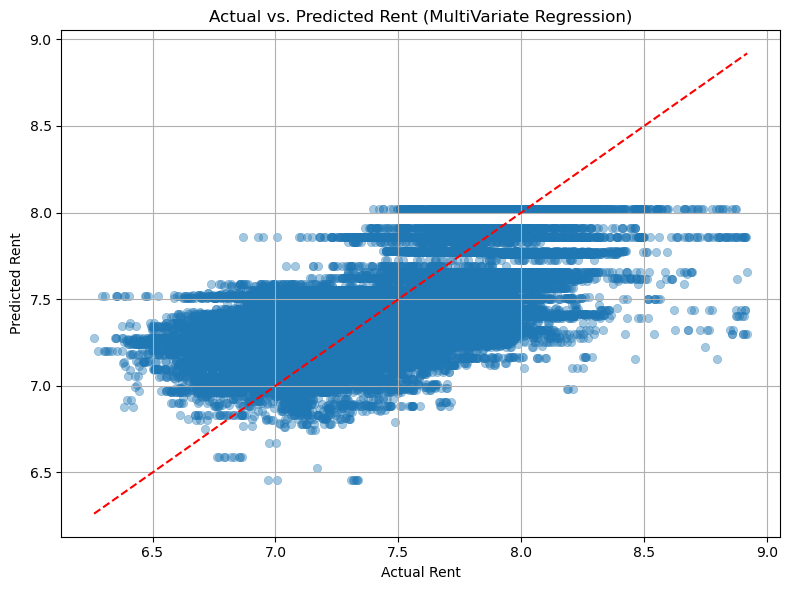

In [857]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, edgecolor=None)

# Add reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Actual vs. Predicted Rent (MultiVariate Regression)')
plt.grid(True)
plt.tight_layout()
plt.show()


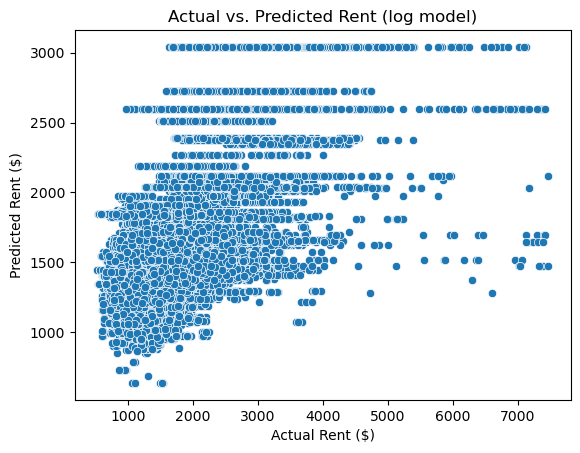

In [861]:
sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred))
plt.xlabel('Actual Rent ($)')
plt.ylabel('Predicted Rent ($)')
plt.title('Actual vs. Predicted Rent (log model)')
plt.show()

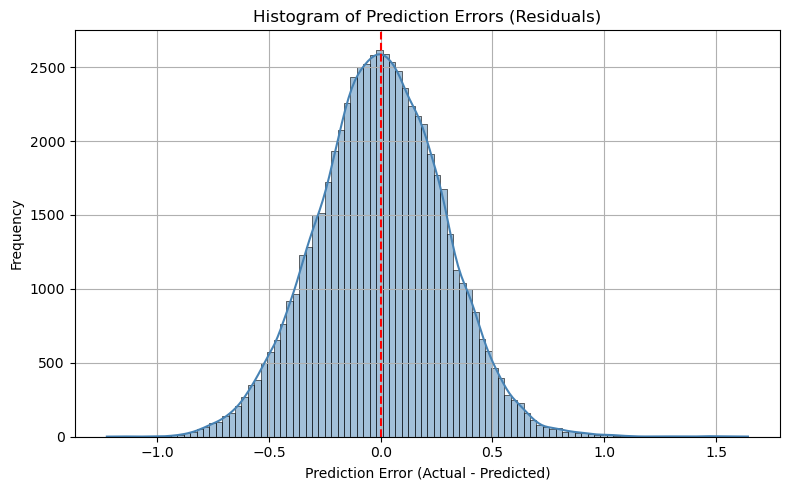

In [863]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=100, kde=True, color='steelblue')

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors (Residuals)')
plt.grid(True)
plt.tight_layout()
plt.show()

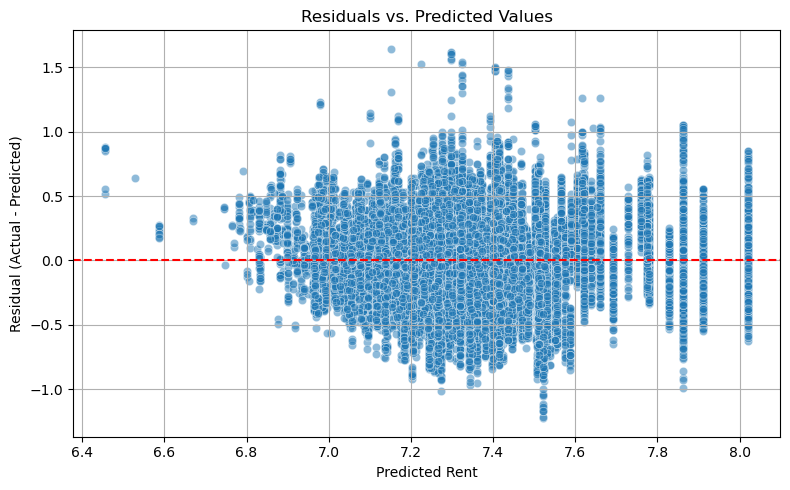

In [869]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rent')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()

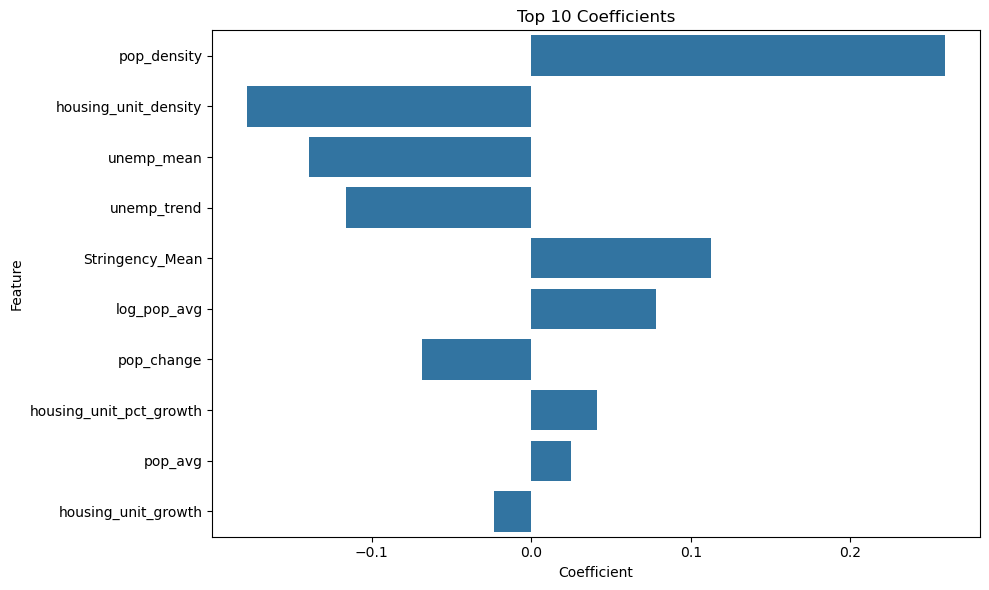

In [871]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Feature')
plt.title("Top 10 Coefficients")
plt.tight_layout()
plt.show()


In [885]:
# Create a clean numeric-only dataset and preserve index
X_cluster = df_model.drop(columns=['Rent (Smoothed)']).select_dtypes(include='number')
X_cluster = X_cluster.dropna()  # Removes rows with NaNs
X_cluster_index = X_cluster.index  # Save index to reassign later

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

In [889]:
from sklearn.utils            import resample          # for random sampling
from sklearn.cluster          import KMeans
from sklearn.metrics          import silhouette_score

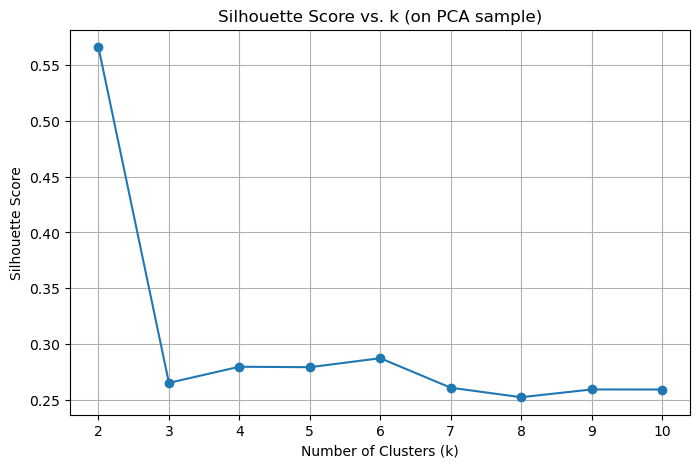

In [891]:
# Sample for silhouette testing
X_sample = resample(X_pca, n_samples=2000, random_state=42)
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)

# Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k (on PCA sample)")
plt.grid(True)
plt.show()

In [406]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample


In [893]:
k_best = 3
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_pca)

# Assign cluster labels ONLY to rows used in PCA
df_model_clustered = df_model.loc[X_cluster_index].copy()
df_model_clustered['Cluster'] = cluster_labels

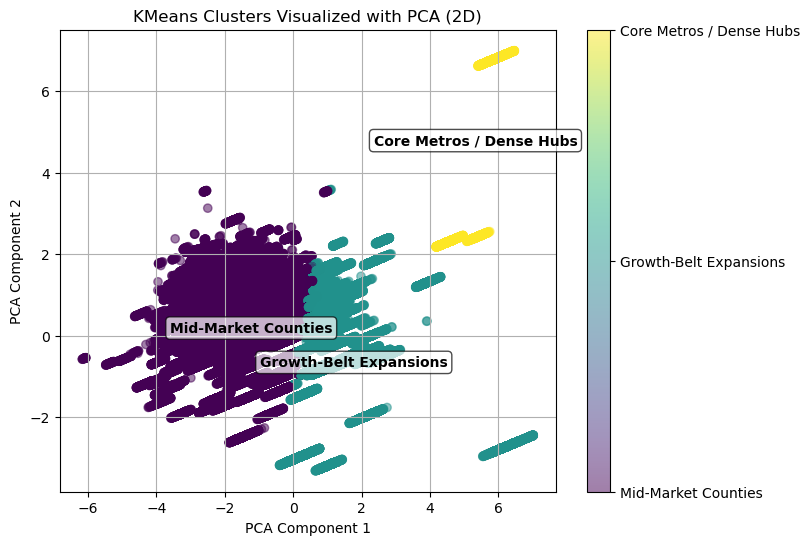

In [926]:

# Descriptive names for each cluster ID
cluster_name_map = {
    0: "Mid-Market Counties",
    1: "Growth-Belt Expansions",
    2: "Core Metros / Dense Hubs"
}

# Two-component PCA for visualisation
pca_2d = PCA(n_components=2)
X_vis  = pca_2d.fit_transform(X_scaled)   

# Scatter plot 
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
        X_vis[:, 0], X_vis[:, 1],
        c=cluster_labels,               
        cmap='viridis',
        alpha=0.50
     )

ax.set_title("KMeans Clusters Visualized with PCA (2D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.grid(True)

# Colour-bar with labels
cbar = plt.colorbar(sc, ticks=sorted(cluster_name_map.keys()))
cbar.ax.set_yticklabels([cluster_name_map[k] for k in sorted(cluster_name_map)])

#Text labels at each cluster’s centroid
for k in np.unique(cluster_labels):
    mask       = cluster_labels == k
    x_centroid = X_vis[mask, 0].mean()
    y_centroid = X_vis[mask, 1].mean()
    ax.text(
        x_centroid, y_centroid,
        cluster_name_map[k],
        fontsize=10, fontweight='bold',
        ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
    )

plt.show()


In [899]:
df_model_clustered[['pop_density',
                    'housing_unit_pct_growth', 'unemp_mean']].dtypes

pop_density                float64
housing_unit_pct_growth    float64
unemp_mean                 float64
dtype: object

In [934]:
cols_to_fix = ['pop_density', 'pop_avg',
               'housing_unit_pct_growth', 'unemp_mean', 'Stringency_Mean']

for col in cols_to_fix:
    df_model_clustered[col] = pd.to_numeric(df_model_clustered[col], errors='coerce')

In [936]:
df_model_clustered.groupby('Cluster')[cols_to_fix].mean().round(2)


,pop_density,pop_avg,housing_unit_pct_growth,unemp_mean,Stringency_Mean
Cluster,,,,,
0,0.00,591350.86,0.03,4.87,52.06
1,0.00,3092858.24,0.02,6.64,55.31
2,0.02,1979434.98,0.01,8.60,62.56


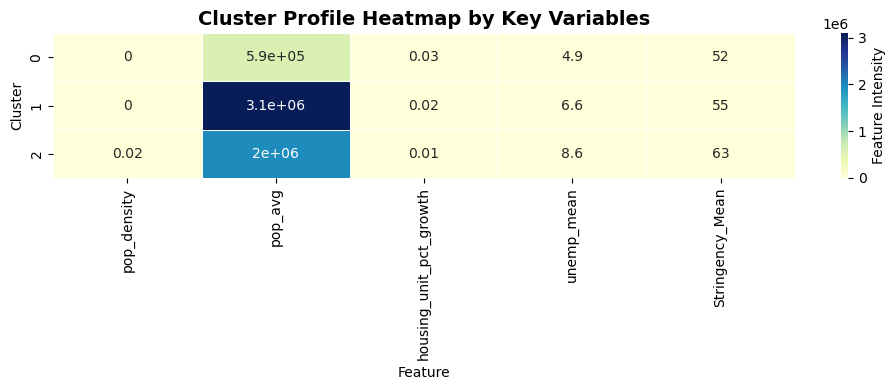

In [938]:
plt.figure(figsize=(10, 4))
sns.heatmap(
    df_model_clustered.groupby('Cluster')[cols_to_fix].mean().round(2),
    annot=True,
    cmap="YlGnBu",
    cbar_kws={'label': 'Feature Intensity'},
    linewidths=0.5
)
plt.title('Cluster Profile Heatmap by Key Variables', fontsize=14, weight='bold')
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [940]:
import seaborn as sns

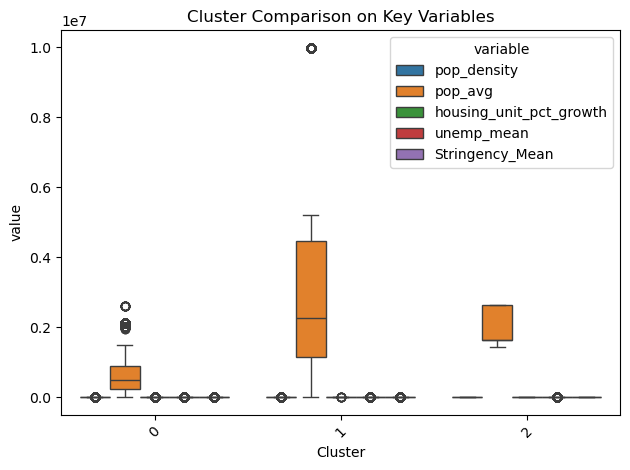

In [942]:
melted = df_model_clustered.melt(id_vars='Cluster', value_vars=cols_to_fix)
sns.boxplot(data=melted, x='Cluster', y='value', hue='variable')
plt.title('Cluster Comparison on Key Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [944]:
import pandas as pd
import numpy as np

# 1.  Build a DataFrame of loadings (weights) for every component
loading_df = (
    pd.DataFrame(
        pca.components_.T,                               # transpose so rows = features
        index=X_cluster.columns,                         # original feature names
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
)

# 2.  Examine the top (absolute) contributors to PC-1 and PC-2
def top_loadings(component, n=10):
    """Return the n features with largest absolute loading for a given PC."""
    return (
        loading_df[component]
        .pipe(lambda s: s.reindex(s.abs().sort_values(ascending=False).index))
        .head(n)
    )

print("Top drivers of PC-1:")
display(top_loadings("PC1", n=15))

print("\nTop drivers of PC-2:")
display(top_loadings("PC2", n=15))


Top drivers of PC-1:


unemp_mean                 0.384987
pop_avg                    0.351127
unemp_trend               -0.349430
log_pop_avg                0.333789
pop_pct_change            -0.308746
pop_change                -0.275835
Stringency_Mean            0.268760
log_rent                   0.249452
housing_unit_pct_growth   -0.235240
pop_density                0.232068
housing_unit_density       0.217746
housing_unit_growth        0.180289
Region Type                0.000000
Name: PC1, dtype: float64


Top drivers of PC-2:


housing_unit_growth       -0.510929
housing_unit_density       0.389980
pop_density                0.383248
pop_avg                   -0.367162
log_pop_avg               -0.331921
housing_unit_pct_growth   -0.263455
Stringency_Mean            0.255525
pop_pct_change            -0.176703
unemp_trend                0.118825
log_rent                   0.087424
unemp_mean                -0.061881
pop_change                -0.059097
Region Type               -0.000000
Name: PC2, dtype: float64